In [118]:
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import yfinance as yf
import pandas as pd
import numpy as np
import os
from scipy.stats import norm

plt.style.use('Solarize_Light2')

### Constants

In [119]:
WINDOW = 21

n_ema = f"{WINDOW}-EMA"

### Loading data

In [120]:
if os.path.exists("data.csv"):
    df = pd.read_csv("data.csv", index_col=0)
else:
    gold_ticker = yf.Ticker("GC=F")
    df = gold_ticker.history(period="max", interval='1h')
    df.to_csv("data.csv")

df.index = pd.to_datetime(df.index, utc=True)

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)
df.columns = df.columns.str.lower()

# display(df.shape)
# display(df.head(3))

### Creating needed metrics

In [121]:
df[n_ema] = df['close'].ewm(span=WINDOW, adjust=False).mean()

df['extension_high'] = np.where(df['high'] > df[n_ema], df['high'] - df[n_ema], 0)
df['extension_low'] = np.where(df['low'] < df[n_ema], df['low'] - df[n_ema], 0)

df.tail()

,open,high,low,close,21-EMA,extension_high,extension_low
Datetime,,,,,,,
2024-09-30 13:00:00+00:00,2660.800049,2663.600098,2651.699951,2657.100098,2672.425360,0.0,-20.725409
2024-09-30 14:00:00+00:00,2657.000000,2657.899902,2650.199951,2655.000000,2670.841237,0.0,-20.641286
2024-09-30 15:00:00+00:00,2655.100098,2658.100098,2652.000000,2655.300049,2669.428401,0.0,-17.428401
2024-09-30 16:00:00+00:00,2655.500000,2661.000000,2654.899902,2660.800049,2668.644006,0.0,-13.744103
2024-09-30 17:00:00+00:00,2660.800049,2663.399902,2657.800049,2660.199951,2667.876364,0.0,-10.076316


### Looking for an Edge

In [122]:
df['extension_low'].agg(['min']).to_frame('range')

,range
min,-100.392343


In [123]:
df['extension_high'].agg(['max']).to_frame('range')

,range
max,73.828054


- Visualization

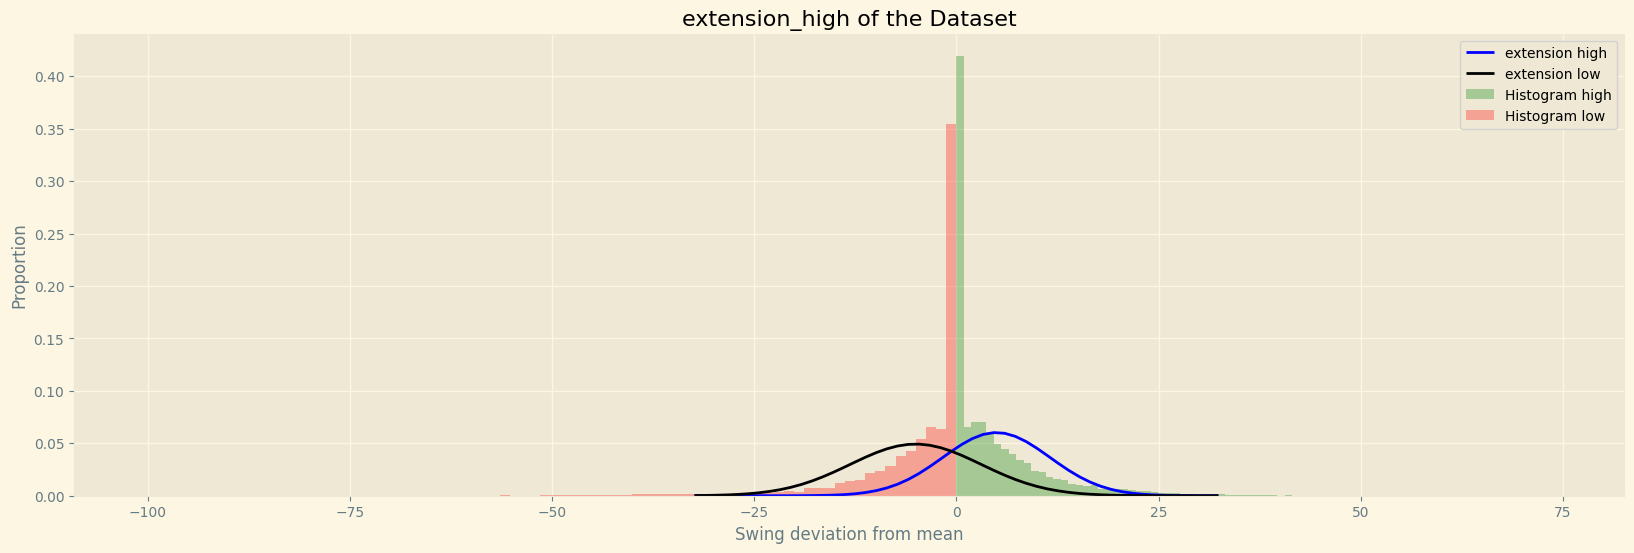

In [124]:
# Step 2: Calculate mean and standard deviation
mean_high, std_dev_high = df['extension_high'].mean(), df['extension_high'].std()
mean_low, std_dev_low = df['extension_low'].mean(), df['extension_low'].std()

std_dev = max(std_dev_high, std_dev_low)

n = 4

# Step 3: Generate x values for the extension
x = np.linspace(-n * std_dev, n * std_dev)
y_high = norm.pdf(x, mean_high, std_dev_high)
y_low = norm.pdf(x, mean_low, std_dev_low)

# Step 4: Plot the extension_high
plt.figure(figsize=(20, 6))

plt.plot(x, y_high, label='extension high', color='blue')
plt.plot(x, y_low, label='extension low', color='black')
plt.hist(df['extension_high'], bins=80, density=True, alpha=0.3, color='green', label='Histogram high')
plt.hist(df['extension_low'], bins=80, density=True, alpha=0.3, color='red', label='Histogram low')

plt.title('extension_high of the Dataset')
plt.xlabel('Swing deviation from mean')
plt.ylabel('Proportion')
plt.legend()
plt.show()

### Strategy

In [125]:
PRICE_DEVIATION = {
    'LOW': -75,
    'HIGH': 60
}

TRADE_OPTIONS = {
    'SL': 80,
    'TP': 40
}

SIGNALS = {
    'BUY': 1,
    'SELL': -1
}

sell_filter = df['extension_high'] > PRICE_DEVIATION['HIGH']
buy_filter = df['extension_low'] < PRICE_DEVIATION['LOW']

df['Signal'] = 0  # Default to hold/no position
df.loc[buy_filter, 'Signal'] = SIGNALS['BUY']  # Buy signal
df.loc[sell_filter, 'Signal'] = SIGNALS['SELL']  # Sell signal

In [126]:
df.reset_index(inplace=True)

df['PnL'] = 0.0

is_trade_on = False

entry = 0.0
sl = 0.0
tp = 0.0

def trade_off():
    global is_trade_on
    global entry
    global sl

    is_trade_on = False
    entry = 0.0
    sl = 0.0

# Loop through candles and execute trades
for i, row in df.iterrows(): # row for reading, i for writing
    if is_trade_on:
        is_long = tp - sl > 0
        if is_long:
            if row['low'] <= sl:
                df.loc[i, 'PnL'] = -1
                trade_off()
            if row['high'] > tp:
                df.loc[i, 'PnL'] = 1
                trade_off()
        else:
            if row['high'] >= sl:
                df.loc[i, 'PnL'] = -1
                trade_off()
            if row['low'] < tp:
                df.loc[i, 'PnL'] = 1
                trade_off()
    else:
        if row['Signal'] == SIGNALS['BUY']:
            is_trade_on = True
            entry = row[n_ema] + PRICE_DEVIATION['LOW']
            sl = entry - TRADE_OPTIONS['SL']
            tp = entry + TRADE_OPTIONS['TP']
            if row['low'] <= sl: # instant check
                df.loc[i, 'PnL'] = -1
                trade_off()

        if row['Signal'] == SIGNALS['SELL']:
            is_trade_on = True
            entry = row[n_ema] + PRICE_DEVIATION['HIGH']
            sl = entry + TRADE_OPTIONS['SL']
            sl = entry - TRADE_OPTIONS['TP']
            if row['high'] >= sl: # instant check
                df.loc[i, 'PnL'] = -1
                trade_off()

In [127]:
df['PnL'].value_counts(normalize=True).to_frame()

,proportion
PnL,
0.0,0.999738
1.0,0.000175
-1.0,0.000087


In [128]:
df[df['PnL'] != 0]['PnL'].count()

3

In [129]:
df['Cumulative_PnL'] = df['PnL'].cumsum()

df['Cumulative_PnL'].iloc[-1]

1.0

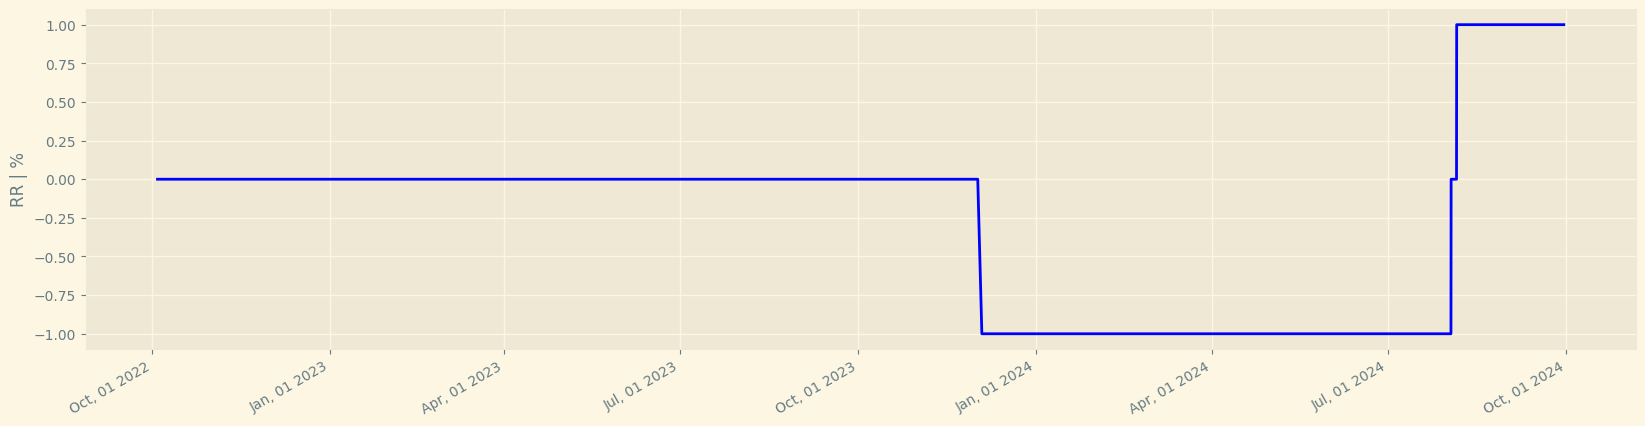

In [130]:
df.set_index('Datetime', inplace=True)

# Plot the Strategy returns
df['Cumulative_PnL'].plot(
        label='Strategy', 
        figsize=(20, 5), 
        color='blue', 
        xlabel='',
        ylabel='RR | %'
    )

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)